# HW2: Self- and Semi-supervised Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw2.html>

## Configuration


In [ ]:
device = 'cpu' # probably don't need GPU for this assignment.


# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`.

That will let us use the starter code in this notebook.

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [ ]:
import sys
import os

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [ ]:
if COLAB:
    if not os.path.exists(os.path.join('/content/drive/MyDrive/', 'CS152L3D_2024f')):
        !cd /content/drive/MyDrive/ && mkdir CS152L3D_2024f


In [ ]:
# Move notebook working directory into the folder
if COLAB:
    %cd /content/drive/MyDrive/CS152L3D_2024f/

    # Clone the repo
    if not os.path.exists('cs152l3d-24f-assignments/hw2/'):
      !git clone https://github.com/tufts-ml-courses/cs152l3d-24f-assignments

    # cd into repo
    %cd cs152l3d-24f-assignments/hw2/

Check for success. We should be able to see files like

* data_utils.py
* train_super.py
* ...


In [ ]:
!ls

MLPClassifier.py              fig3b.jpg
__pycache__                   fig3c.jpg
best_model.pth                hw2.ipynb
data_half_moons               hw2_template.tex
data_utils.py                 l3d_24f_cpu.yml
data_utils_pseudolabel.py     losses_simclr.py
fig1a.jpg                     losses_supervised.py
fig1b.jpg                     run_nb_with_clean_metadata.sh
fig2a.jpg                     train_self.py
fig2b.jpg                     train_super.py
fig2c.jpg                     viz_utils.py
fig3a.jpg


In [ ]:
if COLAB:
    try:
        import torchinfo
    except ImportError:
        rstr = '''
            torchinfo
            '''
        with open('colab_requirements.txt', 'w') as f:
            f.write(rstr)
        !pip install -r colab_requirements.txt
        import torchinfo

In [ ]:
DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('data_half_moons'))
print(DATA_DIR)


/Users/mhughes/courses/cs152l3d-24f-assignments/hw2/data_half_moons


In [ ]:
# Show contents of data dir
!ls $DATA_DIR/

test_x.csv.gz  test_y.csv.gz  train_x.csv.gz train_y.csv.gz unlab_x.csv.gz


# Import Libraries

In [ ]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm
import copy
import time

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torchinfo
import torch

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import utils from provided local starter code files
import data_utils
import MLPClassifier


In [ ]:
import train_super
import losses_supervised

In [ ]:
# For Problem2
import data_utils_pseudolabel

In [ ]:
# For Problem3
import losses_simclr
import train_self

In [ ]:
import viz_utils

# Show basic MLPClassifier architecture


Pretty-print layer-by-layer info

In [ ]:
model = MLPClassifier.MLPClassifier(hidden_layer_sizes=[32,2,2],
                                    activation_functions=['relu','relu', 'l2normalization'],
                                    n_output_classes=2)

Setup complete. Trainable parameter count=174 over 8 tensors in layers: encoder.hidden0,encoder.hidden1,encoder.hidden2,output.


In [ ]:
torchinfo.summary(model, (1,2),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                       Output Shape       Param #
MLPClassifier (MLPClassifier)                 [1, 2]             --
├─Sequential (encoder)                        [1, 2]             --
│    └─Linear (hidden0)                       [1, 32]            96
│    └─ReLU (hidden0_act)                     [1, 32]            --
│    └─Linear (hidden1)                       [1, 2]             66
│    └─ReLU (hidden1_act)                     [1, 2]             --
│    └─Linear (hidden2)                       [1, 2]             6
│    └─L2NormalizationLayer (hidden2_act)     [1, 2]             --
├─Linear (output)                             [1, 2]             6
Total params: 174
Trainable params: 174
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Load dataset

In [ ]:
bigtr_loader, bigva_loader, _, _ = data_utils.make_moons_data_loaders(
    DATA_DIR,
    batch_size=128,
    frac_valid=0.2,
    n_samples_per_class_trainandvalid=160)

splitname   0   1
    train 128 128
    valid  32  32
     test 276 236


In [ ]:
tr_loader, va_loader, te_loader, unlab_loader = data_utils.make_moons_data_loaders(
    DATA_DIR,
    batch_size=128,
    frac_valid=0.5,
    n_samples_per_class_trainandvalid=10)

splitname   0   1
    train   5   5
    valid   5   5
     test 276 236


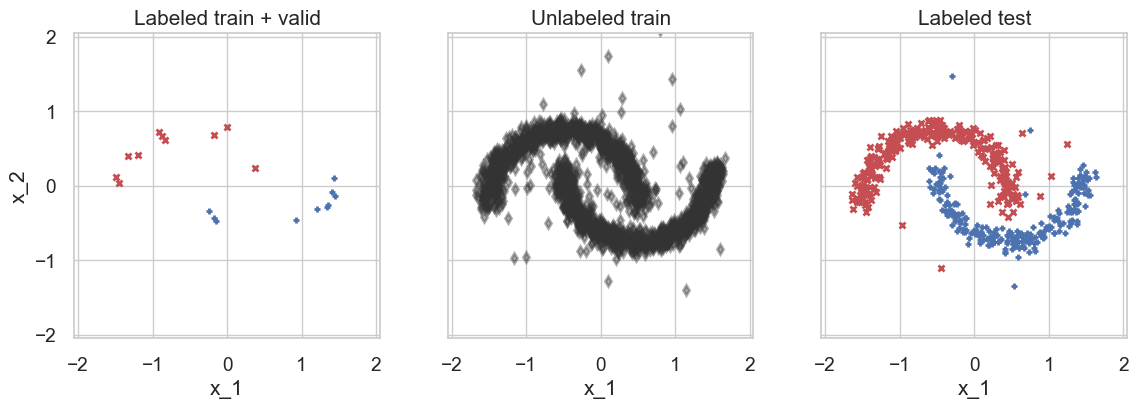

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True);
plt.sca(axgrid[0]);
viz_utils.plot_data_colored_by_labels(
    tr_loader.dataset.dataset.x_N2, tr_loader.dataset.dataset.targets);
plt.sca(axgrid[1]);
viz_utils.plot_data_colored_by_labels(
    unlab_loader.dataset.dataset.x_N2, None);
plt.sca(axgrid[2]);
viz_utils.plot_data_colored_by_labels(
    te_loader.dataset.dataset.x_N2, te_loader.dataset.dataset.targets);
axgrid[0].set_title("Labeled train + valid");
axgrid[1].set_title("Unlabeled train");
axgrid[2].set_title("Labeled test");
plt.tight_layout();
plt.show();

In [ ]:
xbigtr_B2, ybigtr_B = next(iter(bigtr_loader)) # Extract ONE BATCH of big train data (B=128)

In [ ]:
xtr_N2, ytr_N = next(iter(tr_loader)) # Extract small tr data from tr_loader (N=5)

In [ ]:
xte_B2, yte_B = next(iter(te_loader)) # Extract ONE BATCH of test data

In [ ]:
xu_B2 = next(iter(unlab_loader)) # Extract ONE BATCH of unlabeled data

In [ ]:
print("BIG train set batch size", xbigtr_B2.shape[0])
print("SMALL tr  set total size", xtr_N2.shape[0])

BIG train set batch size 128
SMALL tr  set total size 10


In [ ]:
# Extract ALL unlabeled data into one tensor
xunlab_U2 = unlab_loader.dataset.dataset.x_N2

U = xunlab_U2.shape[0]
print("Total unlabeled set size:", U)


Total unlabeled set size: 2048


# Problem 1 Implementation Tasks

No editing needed, but please review the functionality of

* MLPClassifier.py
* train_super.py

# Problem 1 Experiments

We'll now try to fit baseline "labeled-set-only" supervised models to our data.

Need to find good hyperparameters (seed, lr, n_epochs)

Your goal when tuning is to get good values of **validation-set cross-entropy**.

In [ ]:
seed=1001      # TODO try several random initializaitons of model parameters
n_epochs=8     # TODO have you run *long* enough?
lr=0.100       # TODO are your steps converging? making big enough progress per step?

PROB1a_l2pen_mag=0.0

## Experiment 1a: Fit model to BIG train set (128 examples per class to train, 32/class in validation)

In [ ]:
best1a_model, best1a_info = train_super.train_model(
    MLPClassifier.MLPClassifier(seed=seed),
    'cpu',
    bigtr_loader, bigva_loader, # <<<--- using BIG train set and BIG val set
    losses_supervised,
    n_epochs=n_epochs,
    lr=lr,
    l2pen_mag=PROB1a_l2pen_mag,
    data_order_seed=seed)

Setup complete. Trainable parameter count=174 over 8 tensors in layers: encoder.hidden0,encoder.hidden1,encoder.hidden2,output.


100%|█| 9/9 [00:00<00:00, 43.32it/s, tr_xent=0.618, tr_err=0.16, va_xent=0.588, va_err

Finished after epoch 8, best epoch=8
best va_xent 0.588


## Figure 1a: Best supervised model on BIG train set

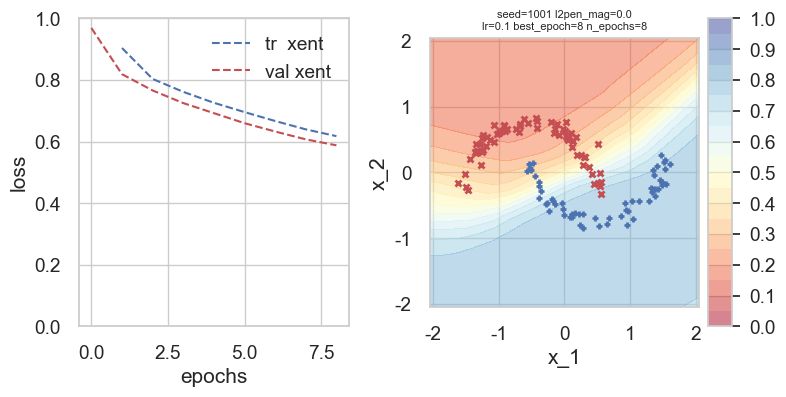

In [ ]:
axgrid = viz_utils.plot_losses_and_learned_boundary(best1a_model, best1a_info, xbigtr_B2, ybigtr_B)
axgrid[0].set_ylim([0, 1.0]);
plt.savefig('fig1a.jpg', bbox_inches='tight', pad_inches=0)
plt.show();

## Experiment 1b: Fit model to SMALL train set (5 examples / class train, 5 / class valid)

In [ ]:
PROB1b_l2pen_mag = 2.0   # Avoid overconfidence

In [ ]:
PROB1b_seed = 1002
PROB1b_lr = 0.100
PROB1b_n_epochs = 8

In [ ]:
best1b_model, best1b_info = train_super.train_model(
    MLPClassifier.MLPClassifier(seed=PROB1b_seed),
    'cpu',
    tr_loader, va_loader, # <<<--- using SMALL train set and SMALL val set
    losses_supervised,
    n_epochs=PROB1b_n_epochs,
    lr=PROB1b_lr,
    l2pen_mag=PROB1b_l2pen_mag,
    data_order_seed=PROB1b_seed)

Setup complete. Trainable parameter count=174 over 8 tensors in layers: encoder.hidden0,encoder.hidden1,encoder.hidden2,output.


100%|█| 9/9 [00:00<00:00, 137.78it/s, tr_xent=0.946, tr_err=0.4, va_xent=0.921, va_err

Finished after epoch 8, best epoch=8
best va_xent 0.921


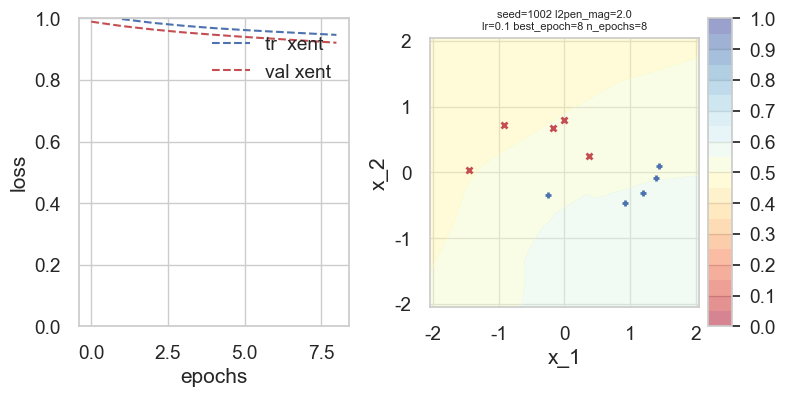

In [ ]:
axgrid = viz_utils.plot_losses_and_learned_boundary(best1b_model, best1b_info, xtr_N2, ytr_N)
axgrid[0].set_ylim([0, 1.0]);
plt.savefig('fig1b.jpg', bbox_inches='tight', pad_inches=0)
plt.show();

# Problem 2: Semi-supervised learning with Curriculum Pseudolabel

## Experiment 2a

In [ ]:
# Recall we've loaded ALL unlabeled data into tensor named xunlab_U2
# As needed, do some experiments here to verify your implementation of make_pseudolabels_for_most_confident_fraction

## Fig 2a: Visualizing datasets constructed by pseudolabeling

As starter code, plot deliberately shows *random* pseudolabels.

Once your correct implementation is ready, you should not see intermingled red/blue, but strong regions of all red or all blue.

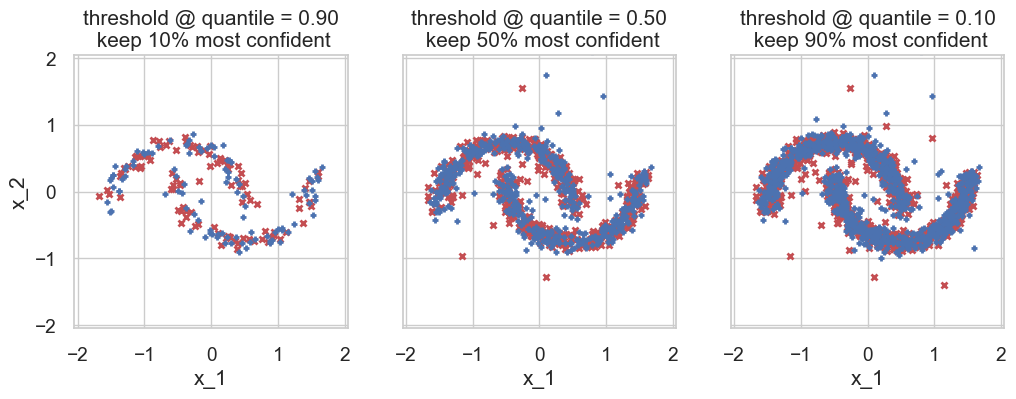

In [ ]:
# Recall we've loaded ALL unlabeled data into tensor named xunlab_U2

quantiles = [0.9, 0.5, 0.1]
_, axgrid = plt.subplots(
    nrows=1, ncols=len(quantiles), figsize=(4*len(quantiles), 4),
    sharex=True, sharey=True)

for panel_id, threshold_quantile in enumerate([0.9, 0.5, 0.1]):
    trch_prng = torch.Generator()
    trch_prng.manual_seed(123)
    xnew_X2, ynew_X = data_utils_pseudolabel.make_pseudolabels_for_most_confident_fraction(
        best1b_model, xunlab_U2, threshold_quantile=threshold_quantile, trch_prng=trch_prng,
        verbose=False)

    plt.sca(axgrid[panel_id]) # use current panel
    viz_utils.plot_data_colored_by_labels(xnew_X2, ynew_X);
    axgrid[panel_id].set_title('threshold @ quantile = %.2f\n keep %.0f%% most confident' % (
        threshold_quantile, 100 - 100*threshold_quantile));

plt.savefig('fig2a.jpg', bbox_inches='tight', pad_inches=0)
plt.show();

## Experiment 2b: Phase 1 of pseudolabel learning (keep top 50%)

Build data loader with thresholding at quantile 0.5 to get pseudolabeled data.

Then train conventionally on this loader.

In [ ]:
PROB2_l2pen_mag = 200. # Avoid overconfidence

In [ ]:
PROB2_seed = 4004
PROB2_lr = 0.100
PROB2_n_epochs = 8

In [ ]:
trch_prng = torch.Generator()
trch_prng.manual_seed(123)
phase1_loader = data_utils_pseudolabel.make_expanded_data_loader(
    best1b_model, tr_loader, unlab_loader, threshold_quantile=0.5, trch_prng=trch_prng)

phase1_model, phase1_info = train_super.train_model(
    MLPClassifier.MLPClassifier(seed=PROB2_seed),
    'cpu',
    phase1_loader, va_loader, # <<<--- using PHASE1 tr set and val set
    losses_supervised,
    n_epochs=PROB2_n_epochs,
    lr=PROB2_lr,
    l2pen_mag=PROB2_l2pen_mag,
    data_order_seed=PROB2_seed)

Setup complete. Trainable parameter count=174 over 8 tensors in layers: encoder.hidden0,encoder.hidden1,encoder.hidden2,output.


100%|█| 9/9 [00:00<00:00, 28.07it/s, tr_xent=1, tr_err=0.503, va_xent=1, va_err=0.5, b


Finished after epoch 8, best epoch=4
best va_xent 1.000


## Figure 2b


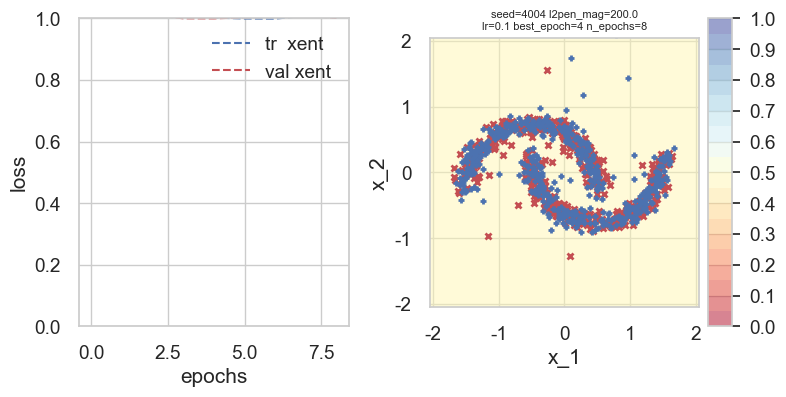

In [ ]:
axgrid = viz_utils.plot_losses_and_learned_boundary(phase1_model, phase1_info, phase1_loader.dataset.tensors[0], phase1_loader.dataset.tensors[1]);
axgrid[0].set_ylim([0, 1.0]);
plt.savefig('fig2b.jpg', bbox_inches='tight', pad_inches=0)
plt.show();

# Constructing possible pseudolabel datasets for phase 2

* Build data loader with thresholding at quantile 0.25 on model from phase 1
* Then train conventionally on this loader.

## Experiment 2c: Phase 2 of pseudolabel learning

In [ ]:
# TODO FIXME
phase2_loader = copy.deepcopy(phase1_loader) # TODO FIXME
# Needed: Call data_utils_pseudolabel.make_expanded_data_loader(...)


phase2_model = copy.deepcopy(phase1_model) # TODO FIXME
phase2_info = copy.deepcopy(phase1_info)   # TODO FIXME
# phase2_model, phase2_info = train_super.train_model(...)


## Figure 2c

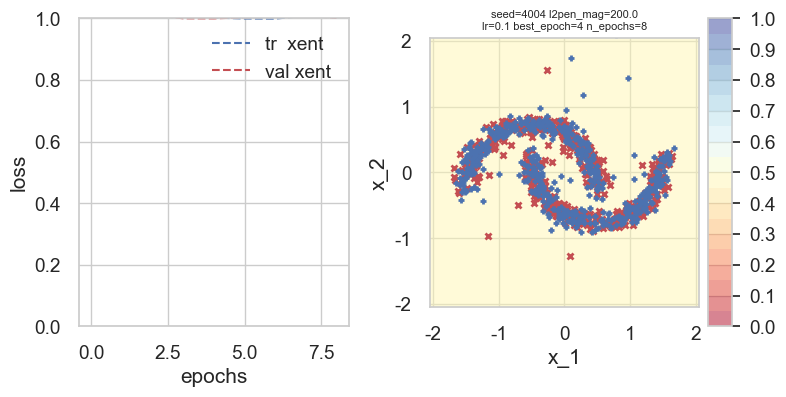

In [ ]:
axgrid = viz_utils.plot_losses_and_learned_boundary(phase2_model, phase2_info, phase2_loader.dataset.tensors[0], phase2_loader.dataset.tensors[1]);
axgrid[0].set_ylim([0, 1.0]);
plt.savefig('fig2c.jpg', bbox_inches='tight', pad_inches=0)
plt.show();

# Problem 3: Self supervised learning with SimCLR

Fixed constants for Problem 3

In [ ]:
TEMP = 0.1     # DO NOT EDIT THESE VALUES.
SIGMA = 0.02

PROB3_l2pen_mag = 0.0

In [ ]:
PROB3_seed = 3001    # TODO EXPLORE THESE VALUES

PROB3_lr = 0.100
PROB3_n_epochs = 4

In [ ]:
simclr_model, simclr_info = train_self.train_model(
    MLPClassifier.MLPClassifier(seed=PROB3_seed),
    'cpu',
    unlab_loader,               # <<<--- using UNLABELED train set
    losses_simclr,
    n_epochs=PROB3_n_epochs,
    lr=PROB3_lr,
    data_order_seed=PROB3_seed,
    unlab_loss_kws={'temp':TEMP, 'sigma':SIGMA},
)

Setup complete. Trainable parameter count=174 over 8 tensors in layers: encoder.hidden0,encoder.hidden1,encoder.hidden2,output.


100%|█████████████████████████| 5/5 [00:00<00:00,  9.89it/s, loss=-181, batch_done=16]


## Figure 3a: Show loss progress over epochs

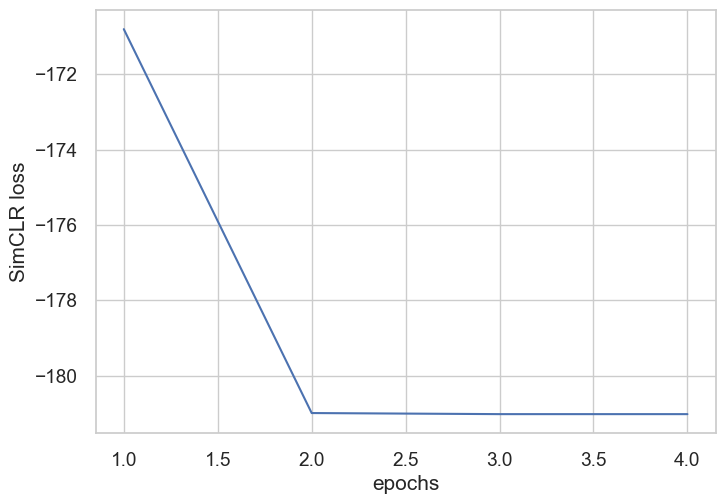

In [ ]:
ax = plt.gca()
ax.plot(simclr_info['epochs'], simclr_info['tr']['loss']);
ax.set_xlabel('epochs');
ax.set_ylabel('SimCLR loss');
plt.savefig('fig3a.jpg', bbox_inches='tight', pad_inches=0);
plt.show();

## Figure 3b: Compare self-supervised representation on unit circle to supervised alternatives

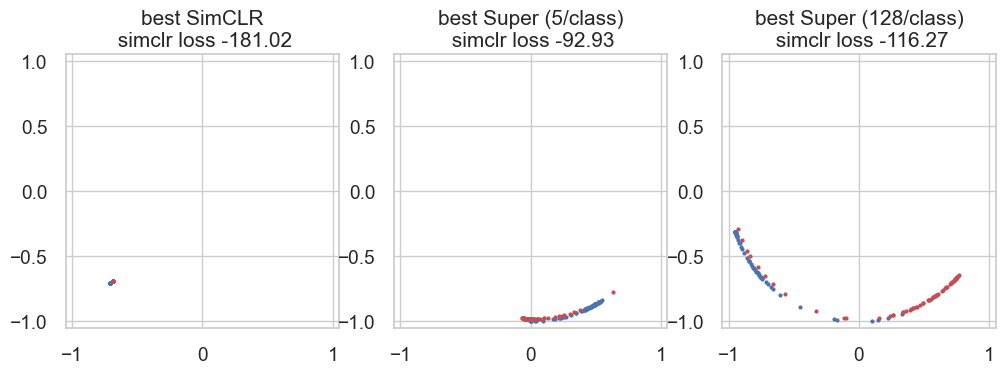

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=3, figsize=(12, 4));
trch_prng = torch.Generator()
trch_prng.manual_seed(3)

plt.sca(axgrid[0]);
loss0 = losses_simclr.calc_self_loss_for_batch(simclr_model, xte_B2, sigma=SIGMA, temp=TEMP, trch_prng=trch_prng)
axgrid[0].set_title("best SimCLR\n simclr loss %6.2f" % loss0)
viz_utils.plot_embeddings_on_unit_circle(simclr_model, xte_B2, yte_B);

plt.sca(axgrid[1]);
loss1 = losses_simclr.calc_self_loss_for_batch(best1b_model, xte_B2, sigma=SIGMA, temp=TEMP, trch_prng=trch_prng)
axgrid[1].set_title("best Super (5/class)\n simclr loss %6.2f" % loss1)
viz_utils.plot_embeddings_on_unit_circle(best1b_model, xte_B2, yte_B);

plt.sca(axgrid[2]);
loss2 = losses_simclr.calc_self_loss_for_batch(best1a_model, xte_B2, sigma=SIGMA, temp=TEMP, trch_prng=trch_prng)
axgrid[2].set_title("best Super (128/class)\n simclr loss %6.2f" % loss2)
viz_utils.plot_embeddings_on_unit_circle(best1a_model, xte_B2, yte_B);

plt.savefig('fig3b.jpg', bbox_inches='tight', pad_inches=0)
plt.show();


## Experiment 3c

In [ ]:
# Supervised fine-tuning of the SimClr model

finetuned_model = copy.deepcopy(simclr_model)
finetuned_model.setup_trainable_parameters(n_trainable_layers=1) # Make only output layer (weight and bias) trainable.

finetuned_info = copy.deepcopy(best1b_info)

# TODO FIXME
# Call train_super.train_model to do fine-tuning of the last layer on tr_loader, va_loader


Setup complete. Trainable parameter count=6 over 2 tensors in layers: output.


## Figure 3c

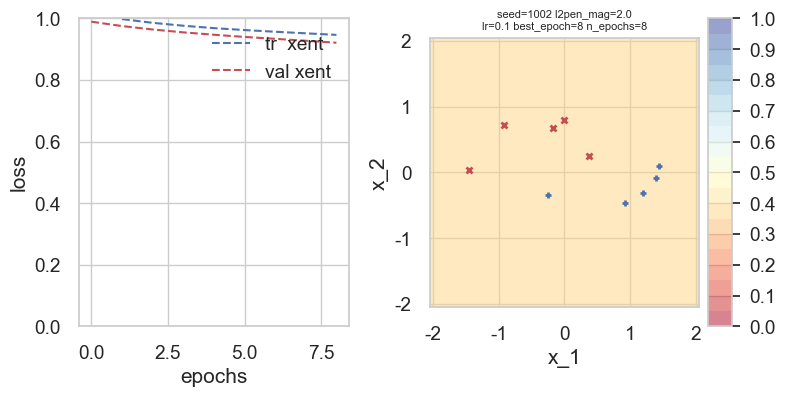

In [ ]:
axgrid = viz_utils.plot_losses_and_learned_boundary(finetuned_model, finetuned_info, xtr_N2, ytr_N)
axgrid[0].set_ylim([0, 1.0]);
plt.subplots_adjust(wspace=0.3);
plt.savefig('fig3c.jpg', bbox_inches='tight', pad_inches=0)
plt.show();

# Problem 4: Head-to-head comparison

In [ ]:
def eval_metrics(model, device, test_loader):
	model.to(device)
	model.eval()
	correct = 0
	xent = 0.0
	with torch.no_grad():
		for x, y in test_loader:
			logit = model(x.to(device))
			correct += torch.sum(logit.argmax(axis=1) == y.to(device)).item()
			xent += losses_supervised.calc_xent_loss_base2(logit, y.to(device), reduction='sum').item()
	return {'acc':correct / len(test_loader.dataset),
		'xent': xent / len(test_loader.dataset),
		}

In [ ]:
super_info = eval_metrics(best1b_model, device, te_loader)
super_info['method'] = 'super'
semi_info = eval_metrics(phase2_model, device, te_loader)
semi_info['method'] = 'PseudoL'
self_info = eval_metrics(finetuned_model, device, te_loader)
self_info['method'] = 'SimCLR+finetune'

row_list = [super_info, semi_info, self_info]

In [ ]:
df = pd.DataFrame(row_list, columns=['method', 'xent', 'acc'])

pd.set_option('display.precision', 3)
df

,method,xent,acc
0,super,0.953,0.760
1,PseudoL,0.999,0.539
2,SimCLR+finetune,1.008,0.539
